# Bollinger Bands

1. Buy when the price crosses the lower Bollinger Band upwards.
2. Sell (only if stocks are in possession) when the price crosses the upper Bollinger Band downward.
3. All-in strategy—when creating a buy order, buy as many shares as possible.
4. Short selling is not allowed.

In [10]:
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline

In [2]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [3]:
data = bt.feeds.PandasData(dataname=yf.download('MSFT', '2018-01-01', '2018-12-31'))

[*********************100%***********************]  1 of 1 completed


In [4]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [5]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 112, Cash: 10000.00, Open: 88.73999786376953, Close: 89.12999725341797
2018-02-12, BUY EXECUTED --- Price: 88.74, Cost: 9938.88, Commission: 9.94
2018-04-19, SELL CREATED --- Size: 112
2018-04-19, SELL EXECUTED --- Price: 96.44, Cost: 9938.88, Commission: 10.80
2018-04-19, OPERATION RESULT --- Gross: 862.40, Net: 841.66
2018-06-29, BUY CREATED --- Size: 109, Cash: 10841.66, Open: 98.93000030517578, Close: 98.61000061035156
2018-06-29, BUY EXECUTED --- Price: 98.93, Cost: 10783.37, Commission: 10.78
2018-07-17, SELL CREATED --- Size: 109
2018-07-17, SELL EXECUTED --- Price: 104.61, Cost: 10783.37, Commission: 11.40
2018-07-17, OPERATION RESULT --- Gross: 619.12, Net: 596.93
2018-10-15, BUY CREATED --- Size: 105, Cash: 11438.59, Open: 108.91000366210938, Close: 107.5999984741211
2018-10-15, Order Failed
2018-10-26, BUY CREATED --- Size: 108, Cash: 11438.59, Open: 105.69000244140625, Close: 106.95999908447266
2018-10-26,

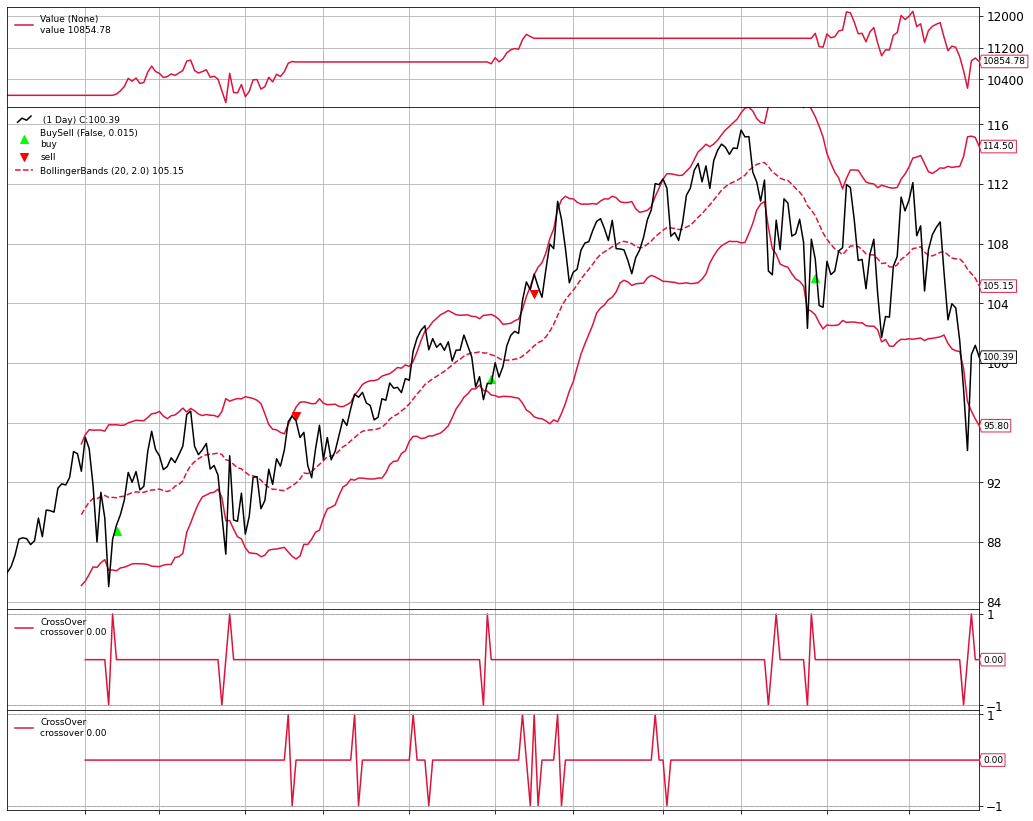

[[<Figure size 1080x864 with 4 Axes>]]

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot=False, volume=False)

In [14]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.08202041312165345), ('ravg', 0.0003280816524866138), ('rnorm', 0.0861904521354339), ('rnorm100', 8.61904521354339)])


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

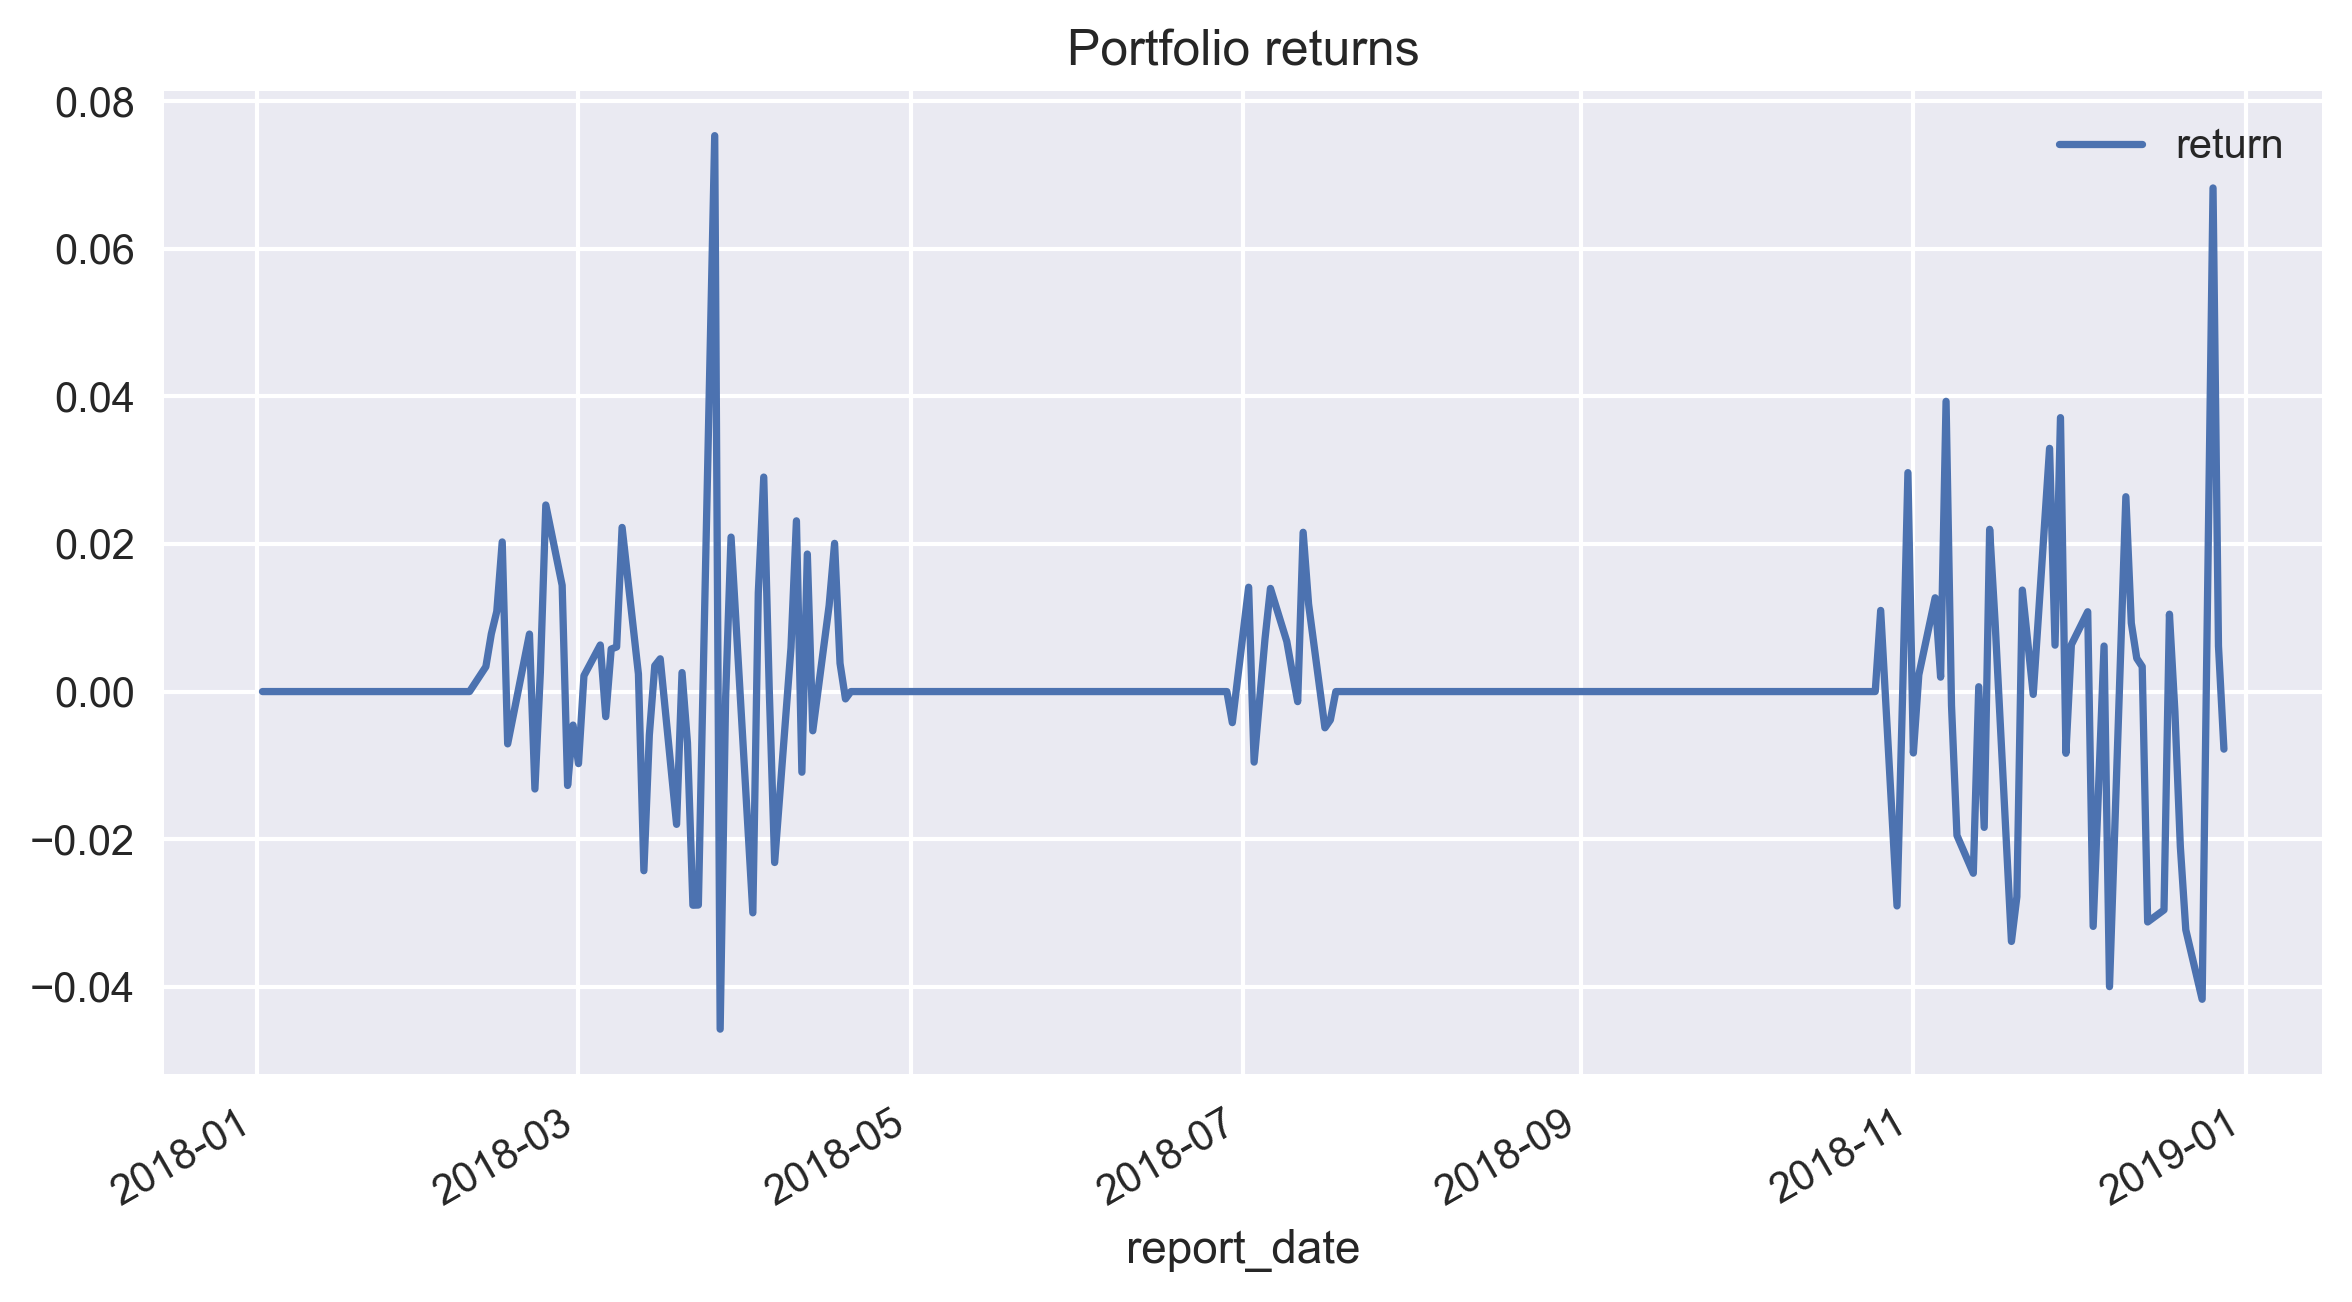

In [20]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ['report_date', 'return']) \
               .set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
plt.show()